#Use Case D - DeepPavlov (using BERT) 

### Revised (June 2022) to read all data with SPARQL queries from the Knowledge Database. Also added the terms and definitions from [Eurostat's Concepts and Definitions Database](https://ec.europa.eu/eurostat/ramon/nomenclatures/index.cfm?TargetUrl=LST_NOM_DTL_GLOSSARY&StrNom=CODED2&StrLanguageCode=EN) in the fine-tuning stage.



* This is a Google Colab notebook. You must have a Google account with a Google Drive to store/ load the model. Upload it from its location in GitHub and allow the code to access your Google Drive.
* Please put your credentials in the cell "Connect to the Virtuoso database".
* Please run the first cell under "Installations" first. This will install the latest release of DeepPavlov and a compatible version of numpy and it may ask you to restart the runtime.
* Fine-tuning can be skipped if already run once. Go to cell "Loading the fine-tuned model", load the saved model and continue.
* See instructions in cell "Configurations" to change the bi-encoder model, to select if you want to see intermediate results when interacting with chatbot, or to change the inputs - full set of proposals (datasets or SE Glossary articles).

### Installations

In [1]:
!pip install numpy==1.21 ## specific for this version
!pip install deeppavlov==1.0.0rc0 ## specific for this version o/w downgrades pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached deeppavlov-1.0.0rc0-py3-none-any.whl (753 kB)
  Using cached fastapi-0.73.0-py3-none-any.whl (52 kB)
  Using cached ruamel.yaml-0.17.20-py3-none-any.whl (109 kB)
     |████████████████████████████████| 8.2 MB 15.9 MB/s 
     |████████████████████████████████| 1.5 MB 7.8 MB/s 
  Using cached uvicorn-0.17.4-py3-none-any.whl (52 kB)
     |████████████████████████████████| 55 kB 4.5 MB/s 
     |████████████████████████████████| 895 kB 41.1 MB/s 
  Using cached prometheus_client-0.13.1-py3-none-any.whl (57 kB)
  Using cached Cython-0.29.27-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
     |████████████████████████████████| 55 kB 4.6 MB/s 
  Using cached pyTelegramBotAPI-4.4.0.tar.gz (147 kB)
     |████████████████████████████████| 503 kB 

In [2]:
!pip install pandas==1.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!apt-get install virtuoso-opensource

Reading package lists... Done
Building dependency tree       
Reading state information... Done
virtuoso-opensource is already the newest version (6.1.6+repack-0ubuntu9).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [4]:
!pip install SPARQLWrapper
!pip install sparql_dataframe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
!pip install sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
!pip install gap-stat

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


###Imports

In [7]:
import os, re, json, ast, random

from typing import List, Set, Tuple
from pathlib import Path

import nltk
import sklearn, torch
import pandas as pd

import numpy as np
import ipywidgets as widgets

from google.colab import data_table, drive

from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

from sentence_transformers import SentenceTransformer, CrossEncoder, util
from sentence_transformers.losses import MultipleNegativesRankingLoss
from sentence_transformers.readers import LabelSentenceReader, InputExample
from torch.utils.data import DataLoader

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

from deeppavlov import build_model
from deeppavlov.core.common.registry import register
from deeppavlov.core.models.component import Component

import matplotlib.pyplot as plt

from gap_statistic import OptimalK

from SPARQLWrapper import SPARQLWrapper, POST, DIGEST, GET
from SPARQLWrapper import JSON
import sparql_dataframe

###Configurations

Please note that, once, the fine-tuning has been run, one can change any of the first two options and skip the fine-tuning (loading instead the saved model). For this, it suffices to:
*    Run only the cell with the selectors,
*    Run only the cell immediately after the selectors,
*    Go to the cell with the title “Loading the fine-tuned model” and choose 
“Runtime > Run after”, which runs the current cell and all following. 


In [8]:
# By Default it loads the first option to every dropdown menu

In [9]:
# Set which dataset to use (either eurostat's datasets or glossary articles)
data_dropdown = widgets.Dropdown(options=["datasets_use_case_d.pkl", "glossary_use_case_d.pkl"])
display(widgets.HBox([widgets.Label(value="Data:"), data_dropdown]))

# Option to show intermediate results when interacting with chatbot 
# Intermediate results include a histogram plot and a table for every chatbot interaction
intermediate_results_dropdown = widgets.Dropdown(options=["Yes", "No"])
display(widgets.HBox([widgets.Label(value="Show intermediate results?: "), intermediate_results_dropdown]))

### Select Bi-encoder model
# Load pre-trained model that we will use as a base for fine tuning or alone
# Warning: loading 2nd or 3rd model for finetuning requires large amounts of memory
bi_encoder_model_dropdown = widgets.Dropdown(options=["multi-qa-MiniLM-L6-cos-v1", "multi-qa-distilbert-cos-v1", "multi-qa-mpnet-base-cos-v1"])
display(widgets.HBox([widgets.Label(value="Bi-encoder model:"), bi_encoder_model_dropdown]))

In [66]:
dataset_to_load = data_dropdown.value
show_inter_results = True if intermediate_results_dropdown.value == 'Yes' else False
bi_encoder = SentenceTransformer(bi_encoder_model_dropdown.value)

In [67]:
path_to_bi_encoder = bi_encoder_model_dropdown.value

In [68]:
print('Settings chosen')
print(f'Data: {dataset_to_load}')
print(f'Show intermediate results?: {intermediate_results_dropdown.value}')
print(f'Bi-encoder model: {bi_encoder_model_dropdown.value}')

Settings chosen
Data: glossary_use_case_d.pkl
Show intermediate results?: Yes
Bi-encoder model: multi-qa-MiniLM-L6-cos-v1


###Auxiliary functions


In [13]:
def SPARQL_query(RelationsStatements):

  sparql.setQuery(RelationsStatements)
  sparql.method = "POST"
  sparql.setReturnFormat(JSON)
  df = sparql.query().convert()['results']['bindings']
  df = pd.json_normalize(df)
  return df



def clean(x, quotes=True):
    if pd.isnull(x): return x  
    x = x.strip()
    
    ## make letter-question mark-letter -> letter-quote-space-letter !!! but NOT in the lists of URLs!!!
    if quotes:
        x = re.sub(r'([A-Za-z])\?([A-Za-z])','\\1\' \\2',x) 
    
    ## make letter-question mark-space lower case letter letter-quote-space letter
    x = re.sub(r'([A-Za-z])\? ([a-z])','\\1\' \\2',x) 

    ## delete ,000 commas in numbers    
    x = re.sub(r'\b(\d+),(\d+)\b','\\1\\2',x) ## CORRECTED
    
    ## delete  000 spaces in numbers
    x = re.sub(r'\b(\d+) (\d+)\b','\\1\\2',x) ## CORRECTED
    
    ## remove more than one spaces
    x = re.sub(r' +', ' ',x)
    
    ## remove start and end spaces
    x = re.sub(r'^ +| +$', '',x,flags=re.MULTILINE) 
    
    ## space-comma -> comma
    x = re.sub(r' \,',',',x)
    
    ## space-dot -> dot
    x = re.sub(r' \.','.',x)
    
    x = re.sub(r'â.{2}',"'",x) ### !!! NEW: single quotes are read as: âXX
    
    return x


### Mount google drive

In [14]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [15]:
user = 'xxxxx'
passw = 'xxxxx'

###Connect to Virtuoso database

In [16]:
def connect_virtuoso(DSN, UID, PWD):

    sparql = SPARQLWrapper(DSN)
    sparql.setHTTPAuth(DIGEST)
    sparql.setCredentials(UID, PWD)
    sparql.setMethod(GET)

    return sparql

# Connection to the KDB 
endpoint = "http://lod.csd.auth.gr:8890/sparql/"
sparql = connect_virtuoso(endpoint,user,passw)

###Loading the datasets information from the database

In [17]:
RelationsStatements = """
PREFIX estat: <https://ec.europa.eu/eurostat/NLP4StatRef/ontology/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
select * where { 
	?dataset  estat:term ?code ;
    rdfs:label ?description;
    estat:databasePath ?path ;
    estat:fileLink ?link.
} 
"""

crumbs_df = SPARQL_query(RelationsStatements)
print(crumbs_df.columns)

Index(['dataset.type', 'dataset.value', 'code.type', 'code.datatype',
       'code.value', 'description.type', 'description.datatype',
       'description.value', 'path.type', 'path.datatype', 'path.value',
       'link.type', 'link.datatype', 'link.value'],
      dtype='object')


In [18]:
crumbs_df.rename(columns={'description.value':'File description','code.value':'File code','path.value':'Names','link.value':'Link'},inplace=True)

crumbs_df.replace('',np.nan,inplace=True)
print(crumbs_df.isnull().sum()) ## check for missing values

crumbs_df['Names'] = crumbs_df['Names'].apply(lambda x: x.split(';'))
crumbs_df['Full path'] = crumbs_df['Names'].apply(lambda x: [y for y in x[1:]]) ## exclude first part

crumbs_df['Full path'] = crumbs_df['Full path'].apply(lambda x: ' '.join(x))

crumbs_df = crumbs_df[['Names','File description','File code','Full path','Link']].copy()
##crumbs_df.reindex(['File code','File description','Names','Link'], axis=1)


# Drop duplicates with the same file code
crumbs_df = crumbs_df.drop_duplicates(subset='File code', keep="first").reset_index(drop=True)
crumbs_df

dataset.type            0
dataset.value           0
code.type               0
code.datatype           0
File code               0
description.type        0
description.datatype    0
File description        0
path.type               0
path.datatype           0
Names                   0
link.type               0
link.datatype           0
Link                    0
dtype: int64


,Names,File description,File code,Full path,Link
0,"[Database by themes, Agriculture, forestry a...",Agricultural labour input statistics absolute ...,aact_ali01,Agriculture forestry and fisheries Agricult...,https://ec.europa.eu/eurostat/estat-navtree-po...
1,"[Database by themes, Agriculture, forestry a...",Agricultural labour input statistics indices,aact_ali02,Agriculture forestry and fisheries Agricult...,https://ec.europa.eu/eurostat/estat-navtree-po...
2,"[Database by themes, Agriculture, forestry a...",Economic accounts for agriculture values at cu...,aact_eaa01,Agriculture forestry and fisheries Agricult...,https://ec.europa.eu/eurostat/estat-navtree-po...
3,"[Database by themes, Agriculture, forestry a...",Economic accounts for agriculture values at n ...,aact_eaa02,Agriculture forestry and fisheries Agricult...,https://ec.europa.eu/eurostat/estat-navtree-po...
4,"[Database by themes, Agriculture, forestry a...",Economic accounts for agriculture values at co...,aact_eaa03,Agriculture forestry and fisheries Agricult...,https://ec.europa.eu/eurostat/estat-navtree-po...
...,...,...,...,...,...
6812,"[Database by themes, Population and social co...",Young people living in households with very lo...,yth_incl_120,Population and social conditions Youth Yout...,https://ec.europa.eu/eurostat/estat-navtree-po...
6813,"[Database by themes, Population and social co...",Frequency of getting together with relatives o...,yth_part_010,Population and social conditions Youth Yout...,https://ec.europa.eu/eurostat/estat-navtree-po...
6814,"[Database by themes, Population and social co...",Frequency of contacts with relatives or friend...,yth_part_020,Population and social conditions Youth Yout...,https://ec.europa.eu/eurostat/estat-navtree-po...
6815,"[Database by themes, Population and social co...",Participation of young people in activities of...,yth_part_030,Population and social conditions Youth Yout...,https://ec.europa.eu/eurostat/estat-navtree-po...


### Loading SE Glossary articles from the database
* Query required even if fine tuning is not needed.
* Titles, URLs and definitions.
* Exclude some redirections.
* Exclude one invalid URL from a remnant empty page.

In [19]:
# query that needs to be calculated even if fine tuning is not needed
RelationsStatements = """
DEFINE input:inference <https://ec.europa.eu/eurostat/NLP4StatRef/knowledge/>
PREFIX estat: <https://ec.europa.eu/eurostat/NLP4StatRef/ontology/>
PREFIX estatdata: <https://ec.europa.eu/eurostat/NLP4StatRef/knowledge/>
select ?a ?title ?url ?content where {
    ?a a estat:GlossaryArticle .
    ?a estat:title ?title .
    ?a estat:hasURL ?url.
    ?a estat:content ?content .
    filter(!regex(?content, "^(The revision|Redirect to)")) 
    filter( regex(?url, "Glossary:")) 
} 
"""
## estat:GlossaryArticle OR StatisticsExplainedArticle

GL_df = SPARQL_query(RelationsStatements)
print(GL_df.columns)  


Index(['a.type', 'a.value', 'title.type', 'title.value', 'url.type',
       'url.datatype', 'url.value', 'content.type', 'content.value'],
      dtype='object')


### GL_df will be added for the fine-tuning. 
### Make a copy 'glossary'. This will be one of the choices for the proposals.

In [20]:
GL_df.rename(columns={'title.value':'title','url.value':'url','content.value':'definition'},inplace=True)
GL_df['id'] = range(len(GL_df))
GL_df = GL_df[['id','title','definition','url']]
glossary = GL_df.copy()

In [21]:
## Skip if already run
if 'File description' not in glossary.columns:
  glossary['definition'] = glossary['definition'].replace('', np.nan)
  glossary.dropna(axis=0,subset=['definition'], inplace=True)

  glossary.reset_index(drop=True, inplace=True)

In [22]:
## Skip if already run
if 'File description' not in glossary.columns:
  glossary['title'] = glossary['title'].apply(clean)
  glossary['title'] = glossary['title'].apply(lambda x: re.sub(r'\?','-',x)) ## also replace question marks by dashes
  # Edit titles in order to remove "Glossary:"
  glossary['title'] = glossary['title'].apply(lambda x: re.sub(r'Glossary:',' ',x)) 
  glossary['definition'] = glossary['definition'].apply(clean)

In [23]:
## Skip if already run
if 'File description' not in glossary.columns:
  # Drop The records with definitions "The revision ..." and "Redirect to ..." 
  idx = glossary[glossary['definition'].str.startswith('The revision #')].index
  glossary.drop(idx , inplace=True)
  idx = glossary[glossary['definition'].str.startswith('Redirect to')].index
  glossary.drop(idx , inplace=True)
  # dropping some pairs that definition is something generic with a link 
  idx = glossary[glossary['definition'].str.startswith('<Brief user-oriented definition')].index 
  glossary.drop(idx , inplace=True)

  glossary.reset_index(drop=True, inplace=True)

In [24]:
## Skip if already run
if 'File description' not in glossary.columns:
  glossary.rename(columns={'id':'article_id'},inplace=True)
  glossary.rename(columns={'url':'Link'},inplace=True)
  #glossary.rename(columns={'definition':'File description'},inplace=True)
  glossary.rename(columns={'title':'File description'},inplace=True) ## CHANGE: put the title in the File description

  #glossary['Full path'] = glossary['title'] + '. ' + glossary['File description']
  glossary['Full path'] = glossary['File description'] + '. ' + glossary['definition']

  glossary

###Save datasets data

In [25]:
# save to pickle in order to be able to load it to DeepPavlov framework
crumbs_df.to_pickle('/content/drive/MyDrive/datasets_use_case_d.pkl')

In [26]:
# save to pickle in order to be able to load it to DeepPavlov framework
glossary.to_pickle('/content/drive/MyDrive/glossary_use_case_d.pkl')

In [27]:
del(crumbs_df,glossary)

###Fine tuning

#### SE Glossary articles as inputs for the fine-tuning 


#### Delete records with empty definitions and carry out data cleansing


In [28]:
GL_df['definition'] = GL_df['definition'].replace('', np.nan)
GL_df.dropna(axis=0,subset=['definition'],inplace=True)

GL_df.reset_index(drop=True, inplace=True)

GL_df['title'] = GL_df['title'].apply(clean)
GL_df['title'] = GL_df['title'].apply(lambda x: re.sub(r'\?','-',x)) ## also replace question marks by dashes
GL_df['title'] = GL_df['title'].apply(lambda x: re.sub(r'Glossary:',' ',x)) 
GL_df['definition'] = GL_df['definition'].apply(clean)

#### Delete "special" records

* i.e. redirections.

In [29]:
# Drop The records with definitions "The revision ..." and "Redirect to ..." 

idx = GL_df[GL_df['definition'].str.startswith('The revision #')].index
GL_df.drop(idx , inplace=True)
idx = GL_df[GL_df['definition'].str.startswith('Redirect to')].index
GL_df.drop(idx , inplace=True)
# dropping some pairs that definition is something generic with a link 
idx = GL_df[GL_df['definition'].str.startswith('<Brief user-oriented definition')].index 
GL_df.drop(idx , inplace=True)

GL_df.reset_index(drop=True, inplace=True)

GL_df.rename(columns={'id':'article_id'},inplace=True)
GL_df.rename(columns={'definition':'content'},inplace=True)
GL_df

,article_id,title,content,url
0,0,Accident at work,An accident at work in the framework of the ad...,https://ec.europa.eu/eurostat/statistics-expla...
1,1,Gross domestic product GDP,Gross domestic product abbreviated as GDP is a...,https://ec.europa.eu/eurostat/statistics-expla...
2,2,Toxicity,Toxicity measures the degree to which a substa...,https://ec.europa.eu/eurostat/statistics-expla...
3,3,Structural fund,The Structural funds are funding instruments t...,https://ec.europa.eu/eurostat/statistics-expla...
4,4,PRODCOM,PRODCOM is an annual survey for the collection...,https://ec.europa.eu/eurostat/statistics-expla...
...,...,...,...,...
1276,1276,Gross operating rate,The gross operating rate in structural busines...,https://ec.europa.eu/eurostat/statistics-expla...
1277,1277,Gross operating surplus,Gross operating surplus or profits is defined ...,https://ec.europa.eu/eurostat/statistics-expla...
1278,1278,Personnel costs,Within the context of structural business stat...,https://ec.europa.eu/eurostat/statistics-expla...
1279,1279,Stratum,In statistics a stratum plural strata refers t...,https://ec.europa.eu/eurostat/statistics-expla...


#### Add paragraphs titles and contents from the SE articles

* Excluding abstracts.

In [30]:
RelationsStatements = """
DEFINE input:inference <https://ec.europa.eu/eurostat/NLP4StatRef/knowledge/>
PREFIX estat: <https://ec.europa.eu/eurostat/NLP4StatRef/ontology/>
PREFIX estatdata: <https://ec.europa.eu/eurostat/NLP4StatRef/knowledge/>
select ?x ?t1 ?c where {
    ?x a estat:StatisticsExplainedArticle .
    ?x estat:hasParagraph  ?h .
    ?h estat:title ?t1 .
    FILTER(?t1!="Abstract") .
    ?h estat:content ?c .
} 
"""
add_content = SPARQL_query(RelationsStatements)  

print(add_content.columns)


Index(['x.type', 'x.value', 't1.type', 't1.value', 'c.type', 'c.value'], dtype='object')


* Also delete duplicate titles.

In [31]:
add_content.rename(columns={'t1.value':'title','c.value':'content'},inplace=True)

## add_content = add_content[['title','content']].copy()

add_content['title'] = add_content['title'].apply(clean).apply(lambda x: re.sub(r'\?','-',x)) ## also replace question marks by dashes
add_content['content'] = add_content['content'].apply(clean)

add_content= add_content.replace('', np.nan) ## Check for anything empty
print(add_content.isnull().sum())

### DELETE NOT EXPRESSIVE TITLES!
### For safety: delete all duplicates
add_content.drop_duplicates(subset=['title'],keep=False,inplace=True)
add_content.reset_index(drop=True, inplace=True)
add_content['article_id'] = range(len(add_content))
add_content = add_content[['article_id','title','content']]
add_content

x.type     0
x.value    0
t1.type    0
title      0
c.type     0
content    0
dtype: int64


,article_id,title,content
0,0,Why is coordination important to support stati...,More and better aid requires coordination and ...
1,1,Who are the key technical and financial partne...,A wide range of international organisations an...
2,2,The technical and financial partners support t...,The PARIS21 consortium plays an important role...
3,3,Eurostat s statistical cooperation unit,Eurostat s statistical cooperation unit provid...
4,4,Official statistics in a nutshell,Definition International principles Statistics...
...,...,...,...
2775,2775,Monthly and quarterly indices,Short term business statistics provide data e ...
2776,2776,Annual overlap method,In the annual overlap method the indices for a...
2777,2777,One quarter overlap method,In the one quarter overlap method the indices ...
2778,2778,Over the year method,In the over the year method the indices for a ...


#### Query to get OECD Glossary data

In [32]:
RelationsStatements = """
DEFINE input:inference <https://ec.europa.eu/eurostat/NLP4StatRef/knowledge/>
PREFIX estat: <https://ec.europa.eu/eurostat/NLP4StatRef/ontology/>
PREFIX estatdata: <https://ec.europa.eu/eurostat/NLP4StatRef/knowledge/>
select ?a ?title ?context ?definition where{
    ?a a estat:OECDTerm .
    ?a estat:term ?title .
    optional { ?a estat:context ?context }
    ?a estat:definition ?definition .
}
"""
OECD_df = SPARQL_query(RelationsStatements)  

print(OECD_df.columns)


Index(['a.type', 'a.value', 'title.type', 'title.value', 'context.type',
       'context.value', 'definition.type', 'definition.value'],
      dtype='object')


In [33]:
OECD_df.rename(columns={'title.value':'term','definition.value':'definition','context.value':'context'},inplace=True)

OECD_df.replace('',np.nan,inplace=True)
print(OECD_df.isnull().sum()) ## check for missing values

OECD_df['term'] = OECD_df['term'].apply(clean).apply(lambda x: re.sub(r'\?','-',x)) ## also replace question marks by dashes
OECD_df['definition'] = OECD_df['definition'].apply(clean)
OECD_df['context'] = OECD_df['context'].apply(clean)

OECD_df['id'] = range(len(OECD_df))
OECD_df = OECD_df[['id','term','definition','context']]

a.type                0
a.value               0
title.type            0
term                  0
context.type       5535
context            5535
definition.type       0
definition            0
dtype: int64


#### Split into two (title,content) collections

In [34]:
#renaming
OECD_df.rename(columns={'id':'article_id'},inplace=True)
OECD_df.rename(columns={'term':'title'},inplace=True)

# using title-definition pairs
OECD_df1 = OECD_df[['article_id','title','definition']].copy()
OECD_df1 = OECD_df1.rename(columns={'definition':'content'})

# using title-context pairs
OECD_df2 = OECD_df[['article_id','title','context']].copy()
OECD_df2 = OECD_df2.rename(columns={'context':'content'})

#OECD_df1 = OECD_df1[['article_id','title','content']].copy()
#OECD_df2 = OECD_df2[['article_id','title','content']].copy()

# deleting empty
OECD_df1['content'] = OECD_df1['content'].replace('', np.nan)
OECD_df1 = OECD_df1.dropna(axis=0,subset=['content'])
OECD_df1['title'] = OECD_df1['title'].replace('', np.nan)
OECD_df1 = OECD_df1.dropna(axis=0,subset=['title'])

OECD_df2['content'] = OECD_df2['content'].replace('', np.nan)
OECD_df2 = OECD_df2.dropna(axis=0,subset=['content'])
OECD_df2['title'] = OECD_df2['title'].replace('', np.nan)
OECD_df2 = OECD_df2.dropna(axis=0,subset=['title'])

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [35]:
OECD_df1

,article_id,title,content
0,0,Abatement cost,Abatement costs refer to expenditures which re...
1,1,Abnormal obsolescence,Abnormal obsolescence is the loss in value of ...
2,2,Abuse of dominant position,The term abuse of dominant position refers to ...
3,3,Accessibility as a statistical data quality di...,The ease and the conditions with which statist...
4,4,Accountability in management theory,A key concept in modern management theory and ...
...,...,...,...
6927,6927,Zero sum game,A game played by a number of persons in which ...
6928,6928,Zero tillage,Refer No tillage
6929,6929,Zones,See Main Economic Indicator main country group...
6930,6930,Zoning,Zoning is the process in physical planning or ...


In [36]:
OECD_df2

,article_id,title,content
0,0,Abatement cost,The calculation of imputed abatement costs doe...
1,1,Abnormal obsolescence,Abnormal obsolescence may occur because of a n...
2,2,Abuse of dominant position,These business practices by the firm not witho...
3,3,Accessibility as a statistical data quality di...,Accessibility refers to the availability of st...
4,4,Accountability in management theory,The person or body to which the manager must r...
...,...,...,...
6590,6590,World Wide Web WWW,Originally developed by the European Laborator...
6591,6591,Year on year changes,Also often referred to as Year over year chang...
6592,6592,Year on year YoY growth rates,Also often referred to as Year over year growt...
6593,6593,Zero coupon bonds,Zero coupon and deep discount bonds have four ...


In [37]:
del(OECD_df)

####Abstracts and context sections from SE articles

In [38]:
RelationsStatements = """
DEFINE input:inference <https://ec.europa.eu/eurostat/NLP4StatRef/knowledge/>
PREFIX estat: <https://ec.europa.eu/eurostat/NLP4StatRef/ontology/>
PREFIX estatdata: <https://ec.europa.eu/eurostat/NLP4StatRef/knowledge/>
select ?x ?title ?url ?partitle ?context ?content where {
    ?x a estat:StatisticsExplainedArticle .
    ?x estat:title ?title .
    ?x estat:hasURL ?url .
    optional{?x estat:context ?context} .
optional {
    ?x estat:hasParagraph  ?h .
    ?h estat:title ?partitle .
    filter(?partitle="Abstract") .
    ?h estat:content ?content .
}
} 
"""
SE_df = SPARQL_query(RelationsStatements)  

print(SE_df.columns)


Index(['x.type', 'x.value', 'title.type', 'title.value', 'url.type',
       'url.datatype', 'url.value', 'partitle.type', 'partitle.value',
       'context.type', 'context.value', 'content.type', 'content.value'],
      dtype='object')


In [39]:
SE_df.rename(columns={'title.value':'title','partitle.value':'has_abstract','url.value':'url','context.value':'context','content.value':'abstract'},inplace=True)

SE_df.replace('',np.nan,inplace=True)
SE_df.replace('NaN',np.nan,inplace=True)
SE_df.replace('nan',np.nan,inplace=True)
SE_df.replace('None',np.nan,inplace=True)

print(SE_df.isnull().sum()) ## check for missing values


SE_df['article_id'] = range(len(SE_df))
SE_df = SE_df[['article_id','context','title','abstract']].copy()

SE_df['title'] = SE_df['title'].apply(clean).apply(lambda x: re.sub(r'\?','-',x)) ## also replace question marks by dashes
SE_df['context'] = SE_df['context'].apply(clean)
SE_df['abstract'] = SE_df['abstract'].apply(clean)



x.type             0
x.value            0
title.type         0
title              0
url.type           0
url.datatype       0
url                0
partitle.type     11
has_abstract      11
context.type     279
context          304
content.type      11
abstract          42
dtype: int64


#### Split into two (title,content) collections

In [40]:
# apply cleaning
SE_df['title'] = SE_df['title'].apply(clean).apply(lambda x: re.sub(r'\?','-',x)) ## also replace question marks by dashes
SE_df['context'] = SE_df['context'].apply(clean)
SE_df['abstract'] = SE_df['abstract'].apply(clean)

# using title-context pairs
SE_df1 = SE_df[['article_id','title','context']]
SE_df1 = SE_df1.rename(columns={'context':'content'})

# using title-abstract pairs
SE_df2 = SE_df[['article_id','title','abstract']]
SE_df2 = SE_df2.rename(columns={'abstract':'content'})

# deleting empty
SE_df1['content'] = SE_df1['content'].replace('', np.nan)
SE_df1 = SE_df1.dropna(axis=0,subset=['content'])

SE_df2['content'] = SE_df2['content'].replace('', np.nan).replace('nan', np.nan)
SE_df2 = SE_df2.dropna(axis=0,subset=['content'])

In [41]:
SE_df1

,article_id,title,content
0,0,Chemicals production and consumption statistics,The General Union Environment Action Programme...
2,2,Statistical cooperation European Neighbourhood...,The ENP was developed in 2004 with the objecti...
5,5,Intra EU trade exchange of micro data,International trade in goods statistics provid...
7,7,Differences between balance of payments and fo...,The EU is a major player in the global economy...
8,8,Causes of death statistics people over 65,Statistics concerning causes of death among pe...
...,...,...,...
887,887,The EU in the world transport,An efficient and well functioning passenger an...
888,888,Monthly electricity generation from non combus...,Over the last decades the effects of global wa...
889,889,Early estimates of income inequalities during ...,In the current extraordinary context of the Co...
890,890,The EU in the world business,Industrial activities such as manufacturing ar...


In [42]:
SE_df2

,article_id,title,content
0,0,Chemicals production and consumption statistics,This article presents an analysis of indicator...
4,4,Statistics in development cooperation budget s...,This article is part of a set of background ar...
5,5,Intra EU trade exchange of micro data,This article presents the innovative statistic...
6,6,EU Labour Force Survey new methodology from 20...,This article describes the methodology of the ...
7,7,Differences between balance of payments and fo...,Author Robert Obrzut Balance of payments stati...
...,...,...,...
880,880,Short term business statistics observation units,A common definition of observation units also ...
881,881,Short term business statistics quality and scope,This article presents various quality aspects ...
882,882,Short term business statistics revisions,Revisions are defined as any change in a value...
883,883,Short term business statistics seasonal adjust...,This article describes the seasonal adjustment...


In [43]:
del(SE_df)

####Eurostat's Concepts and Definitions Database

In [44]:
RelationsStatements = """
DEFINE input:inference <https://ec.europa.eu/eurostat/NLP4StatRef/knowledge/>
PREFIX estat: <https://ec.europa.eu/eurostat/NLP4StatRef/ontology/>
PREFIX estatdata: <https://ec.europa.eu/eurostat/NLP4StatRef/knowledge/>
select ?a ?term ?definition where {
    ?a a estat:CODEDTerm  .
    ?a estat:term ?term .
    ?a estat:definition ?definition .
} 
"""
CODED_df = SPARQL_query(RelationsStatements)  

print(CODED_df.columns)

Index(['a.type', 'a.value', 'term.type', 'term.value', 'definition.type',
       'definition.value'],
      dtype='object')


In [45]:
CODED_df.rename(columns={'term.value':'title','definition.value':'content'},inplace=True)

CODED_df.replace('',np.nan,inplace=True)
print(CODED_df.isnull().sum()) ## check for missing values


CODED_df['article_id'] = range(len(CODED_df))
CODED_df = CODED_df[['article_id','title','content']].copy()

CODED_df['title'] = CODED_df['title'].apply(clean).apply(lambda x: re.sub(r'\?','-',x)) ## also replace question marks by dashes
CODED_df['content'] = CODED_df['content'].apply(clean)
CODED_df

a.type             0
a.value            0
term.type          0
title              0
definition.type    0
content            0
dtype: int64


,article_id,title,content
0,0,n k rule,A cell is regarded as confidential if the n la...
1,1,Abortion,Induced expulsion of the foetus during the fir...
2,2,Achieved sample size ratio for persons,Ratio of the number of completed personal inte...
3,3,Capital good,Capital goods are goods other than material in...
4,4,Technical expertise,A firms knowledge of and ability to use techno...
...,...,...,...
11215,11215,Taxiway,A defined path on an airport established for t...
11216,11216,Taxonomy,Classification of things according to a presum...
11217,11217,Teacher,A person employed in an official capacity for ...
11218,11218,Technical action plan for agricultural statistics,In order to improve the way in which Community...


####Merging all available glossaries and articles

In [46]:
# merge OECD glossary with add_content, GL_df and SE_df
glossaries = [OECD_df1, OECD_df2, GL_df, add_content, SE_df1, SE_df2, CODED_df]
##glossaries = [OECD_df1, OECD_df2, GL_df, add_content, SE_df1, SE_df2]
merged_glossary = pd.concat(glossaries, ignore_index=True)
merged_glossary = merged_glossary.drop(['url'],axis=1)

del(OECD_df1, OECD_df2, GL_df, add_content, SE_df1, SE_df2, CODED_df, glossaries)
merged_glossary

,article_id,title,content
0,0,Abatement cost,Abatement costs refer to expenditures which re...
1,1,Abnormal obsolescence,Abnormal obsolescence is the loss in value of ...
2,2,Abuse of dominant position,The term abuse of dominant position refers to ...
3,3,Accessibility as a statistical data quality di...,The ease and the conditions with which statist...
4,4,Accountability in management theory,A key concept in modern management theory and ...
...,...,...,...
25043,11215,Taxiway,A defined path on an airport established for t...
25044,11216,Taxonomy,Classification of things according to a presum...
25045,11217,Teacher,A person employed in an official capacity for ...
25046,11218,Technical action plan for agricultural statistics,In order to improve the way in which Community...


In [47]:
# setting all pairs of titles and content to have a label of 1
# this is because all pairs are considered a positive example
merged_glossary['is_pair']=1

#### Keep 80% of data for training and 20% for evaluation of the model

In [48]:
from sklearn.model_selection import train_test_split
train_features, eval_features, train_labels, eval_labels = train_test_split(merged_glossary[['title','content']], 
                                                                            merged_glossary[['is_pair']], 
                                                                            train_size=0.8, 
                                                                            random_state=1,
                                                                            stratify=merged_glossary['is_pair'])

train_features = train_features.reset_index(drop=True)
eval_features = eval_features.reset_index(drop=True)

####Fine tuning bi-encoder (CUDA required)

In [49]:
# convert training examples to the appropriate format
train_examples = []
for i in range(len(train_features)):
  train_examples.append(InputExample(texts=[train_features['title'].iloc[i], train_features['content'].iloc[i]]))

In [50]:
finetune_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)

In [51]:
# MultipleNegativesRankingLoss is a great loss function if you only have positive pairs 
loss = MultipleNegativesRankingLoss(model=bi_encoder)

In [52]:
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator, BinaryClassificationEvaluator, MSEEvaluator
from sentence_transformers import evaluation

sentences1 = list(eval_features['title'])
sentences2 = list(eval_features['content'])
scores_eval = list(eval_labels['is_pair'])

In [53]:
evaluator = evaluation.MSEEvaluator(sentences1, sentences2, teacher_model=bi_encoder)

In [54]:
#cleaning up any CUDA related left-overs
import gc
gc.collect()

50

In [55]:
# Fine-tune the model (BE CAREFUL TO SET A PATH FOR THE FINE-TUNED MODEL)
num_epochs = 10
path_to_save_bi_encoder = '/content/drive/MyDrive/testing_fine_tuning'
bi_encoder.fit(train_objectives=[(finetune_dataloader, loss)], evaluator=evaluator, optimizer_class=torch.optim.AdamW, epochs=num_epochs, output_path=path_to_save_bi_encoder)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1253 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1253 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1253 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1253 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1253 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1253 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1253 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1253 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1253 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1253 [00:00<?, ?it/s]

####Loading the fine-tuned model

In [69]:
fine_tuned_bi_encoder = SentenceTransformer(path_to_save_bi_encoder)
path_to_bi_encoder = path_to_save_bi_encoder

In [70]:
bi_encoder = fine_tuned_bi_encoder

### DeepPavlov

#### Creating Components

\__init\__ functions are called once in the very beggining of components initialization  
\__call\__ functions are called every time the user interacts with chatbot

In [80]:
@register('datasets_retriever')
class DatasetsRetriever(Component):
    def __init__(self, datasets_path: str, pretrained_model: str, top_n: int, path_column: str, **kwargs):
      self.model = SentenceTransformer(pretrained_model)
      self.datasets = pd.read_pickle(datasets_path)
      self.top_n = top_n

      # calculate corpus embeddings and augment dataset with these (so as to compute them only once)
      embeddings = self.model.encode(self.datasets[path_column], convert_to_tensor=True, show_progress_bar=False)
      self.datasets['embeddings'] = list(embeddings.cpu())

    def __call__(self, query: str, datasets: pd.DataFrame = None) -> pd.DataFrame:
      #calculate user's query embedding (initial or augmented)
      query_embedding = self.model.encode(query, convert_to_tensor=True, show_progress_bar=False)

      if datasets is None:
        data_df = self.datasets.copy()
      else:
        data_df = datasets.copy()
      
      data_df.reset_index(drop=True, inplace=True)
      data_df['corpus_id'] = data_df.index

      # top_n refers to number of Eurostat databases we want to retrieve with the bi-encoder
      hits = util.semantic_search(query_embedding, torch.stack(data_df['embeddings'].values.tolist()), top_k=self.top_n)
      hits = hits[0]
      hits_df = pd.DataFrame(hits)

      if 'score' in data_df.columns:
        data_df.drop(['score'], inplace=True, axis=1)
      
      # return the dataset augmented with two columns (bi-encoder corpus embeddings and score)
      data_df = hits_df.merge(data_df, on='corpus_id', how='inner')

      return data_df


@register('datasets_reranker')
class DatasetsReranker(Component):
    def __init__(self, pretrained_model:str, path_column: str, **kwargs):
      self.path_column = path_column
      self.model = CrossEncoder(pretrained_model)
        
    def __call__(self, query: str, top_n_datasets: pd.DataFrame) -> pd.DataFrame:
      # score all retrieved datasets with the cross_encoder
      cross_inp = [[query, top_n_datasets[self.path_column][i]] for i in range(len(top_n_datasets))]

      top_n_datasets['cross_scores'] = self.model.predict(cross_inp)
      top_n_datasets = top_n_datasets.sort_values(['cross_scores'],ascending=False)

      return top_n_datasets

@register('datasets_reducer')
class DatasetsReducer(Component):
    def __init__(self, **kwargs):
      pass
        
    def __call__(self, individual_query: str, intermediate_results:bool , datasets: pd.DataFrame) -> pd.DataFrame:
      # perform kmeans with 2 and 3 clusters on cross_scores, and only keep the cluster
      # that contains the result with best cross-score

      optimalK = OptimalK(clusterer = self._k_means_clustering)
      n_clusters = optimalK(datasets[['cross_scores']], cluster_array=np.arange(2, 4))
      print('Optimal clusters: ', n_clusters)
      print(optimalK.gap_df[['n_clusters', 'gap_value']])
      
      ## repeat with the optimal number of clusters between 2 and 3
      kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(datasets[['cross_scores']])

      datasets['cluster_id'] =  list(kmeans.labels_)
      real_clusters = len(np.unique(datasets['cluster_id']))
      print('real clusters: ',real_clusters)
      if n_clusters == 3 and real_clusters != 3:
        kmeans = KMeans(n_clusters=2, random_state=42).fit(datasets[['cross_scores']])
        datasets['cluster_id'] =  list(kmeans.labels_)

      # plot histogram
      if intermediate_results:
        ax = self._create_plot(datasets, n_clusters, individual_query)
        display(ax)

      datasets = datasets[datasets['cluster_id']==(datasets['cluster_id'].iloc[0])]
      return datasets

    def _k_means_clustering(self, data, num_of_clusters):
      # Include any clustering Algorithm that can return cluster centers
        m = KMeans(random_state=42, n_clusters=num_of_clusters)
        m.fit(data)
        # Return the location of each cluster center, and the labels for each point.
        return m.cluster_centers_, m.predict(data)
    

    def _create_plot(self, datasets, n_clusters, individual_query):
      # use a gray background
      ax = plt.axes(facecolor='#E6E6E6')
      ax.set_axisbelow(True)

      # draw solid white grid lines
      plt.grid(color='w', linestyle='solid')

      # hide axis spines
      for spine in ax.spines.values():
          spine.set_visible(False)
          
      # hide top and right ticks
      ax.xaxis.tick_bottom()
      ax.yaxis.tick_left()

      # lighten ticks and labels
      ax.tick_params(colors='gray', direction='out')
      for tick in ax.get_xticklabels():
          tick.set_color('gray')
      for tick in ax.get_yticklabels():
          tick.set_color('gray')

      for cluster in range(n_clusters):
        ax.hist(datasets['cross_scores'][(datasets['cluster_id'] == cluster)], 5, density=False, histtype='bar',  label='cluster '+str(cluster))
      ax.legend(prop={'size': 10})
      ax.set_xlabel('cross_scores')
      ax.set_title(f'Reduction phase, K-means clusters histogram query={individual_query}')
      plt.pause(0.05)
      return ax

@register('question_generator')
class QuestionGenerator(Component):
  def __init__(self, ngram_range: Tuple[int, int], max_df: float, min_df: float, **kwargs):
    self.ngram_range = ngram_range
    self.max_df = max_df
    self.min_df = min_df
  
  def __call__(self, corpus: pd.Series, stop_words: Set[str], unwanted_words: List[str]) -> Tuple[str, str, List[str]]:
    # exclude 'by' from stopwords (as we think that carries useful information)
    stop_words_copy = stop_words.copy()
    stop_words_copy.remove('by')
    vectorizer = TfidfVectorizer(stop_words=stop_words_copy, ngram_range=self.ngram_range, max_df=self.max_df, min_df=self.min_df, token_pattern='(?u)\\b\\w*[a-zA-Z%&\-/]+\\w*\\b|\\b[0-9]{4}\\b')
    subset = vectorizer.fit_transform(corpus)

    # a vocublulary of tokens that includes all ngrams that have been produced 
    vocabulary_words = vectorizer.get_feature_names_out()
    #print(vocabulary_words)

    # decide on the order that we want to show the user the ngrams (in the clarification question)
    sorted_word_idx = list(np.argsort(np.mean(subset.toarray(), axis=0)))

    # get the index of all unwanted words that are in the words dictionary
    existing_idx = list(map(lambda o: vectorizer.vocabulary_[o], filter(lambda o: o in vectorizer.vocabulary_, unwanted_words)))

    # making sure that the cleaned term will be removed from ngrams to propose
    sorted_idxs = [x for x in sorted_word_idx if x not in existing_idx]
    for idx in sorted_idxs[::-1]:
      question_word = vocabulary_words[idx]
      clean_term = self._clean_term_to_show(question_word)
      if clean_term not in unwanted_words:
        break
      else:
        pass

    question = f"bot: {self._choose_question(clean_term)} (yes/no/add some keywords/no with keywords, q to quit) \nme:  "  

    return question_word, question, vocabulary_words

  def _clean_term_to_show(self, input_term):
    # remove 'by' if it is the last token
    tokens = input_term.split()
    if tokens[-1]=='by':
      return ' '.join(tokens[:-1])
    return input_term

  def _choose_question(self, input_term):
  # function to produce a random question 
  
    input_tokens = input_term.split()
    # if ngram starts with 'by'
    if input_tokens[0]=='by':
      question_texts = [f"Would you like to see results {input_term}?", 
                        f"Would you be interested in seeing results {input_term}?",  
                        f"Let's make it more specific. Are you interested in seeing results {input_term}?"]
    # if ngram contains 3 or more tokens (this means that the question becomes very specific)
    elif len(input_tokens)>=3:
      question_texts = [f"What about {input_term}?"]
    else:
      question_texts = [f"Can we make it more specific? Is '{input_term}' related to what you are looking for?", 
                        f"Let's make it more specific. Are you interested in '{input_term}'?",
                        f"I have some results related to '{input_term}'. Is that what you are looking for?",
                        f"It would help me if we could be more specific. Is '{input_term}' related to what you are searching?",
                        f"Would you be interested in '{input_term}'?",
                        f"Is '{input_term}' related to what you are looking for?",
                        f"It would help me if you could provide more details. Is '{input_term}' something related to your query?",
                        f"Please provide more details. Is '{input_term}' something related to what you are looking for?",
                        f"Are you interested to results related to '{input_term}'?",
                        f"Help me please to understand what you mean. Are you referring to '{input_term}'"
      ]
    return random.choice(question_texts)

@register('response_handler')
class ResponseHandler(Component):
  def __init__(self, **kwargs):
    self._stop_words = stopwords.words('english')
    self._stemmer = PorterStemmer()
  
  def __call__(self, question_word: str, input_text: str, answer_text: str, vocabulary_words: List[str], \
               all_unwanted_words: List[str], stop_after_multiple_yes: int, stop_after_multiple_no: int) -> Tuple[str, str, List[str],int, int]:

    if answer_text.lower()=='yes':
      # stop if you reach a threshold for "yes" answers from the user
      stop_after_multiple_yes = stop_after_multiple_yes - 1

      #update the initial query with the new ngram that we proposed (question_word)
      input_text = input_text + ' ' + question_word
      # find all terms that are similar to that ngram proposed and add them to the unwanted words
      all_unwanted_words.extend(self._similar_subset_terms(vocabulary_words, question_word))
      all_unwanted_words = list(set(all_unwanted_words))
      
      # make use of DeepPavlov's Component, to get the updated results based on the augmented user's answer
      return "retrieve_rerank", input_text, all_unwanted_words, stop_after_multiple_yes, stop_after_multiple_no
      ## query_results_df = self._retrieve_and_rerank(input_text, question_word, show_inter_results, query_results_df)

    elif answer_text.lower()=='no':
      # stop if you reach a threshold for "no" answers from the user
      stop_after_multiple_no = stop_after_multiple_no - 1

      # find all terms that are similar to that ngram proposed and add them to the unwanted words
      all_unwanted_words.extend(self._similar_superset_terms(vocabulary_words, question_word))
      all_unwanted_words = list(set(all_unwanted_words))
      return "check_stop", input_text, all_unwanted_words, stop_after_multiple_yes, stop_after_multiple_no

    # user can quit at any time
    elif answer_text.lower()=='q':
      ##break
      return "quit", None, None, None

    # allow user to define what ngrams NOT to ask
    elif answer_text.lower().startswith('no '):
      # treat as providing information
      stop_after_multiple_yes = stop_after_multiple_yes - 1 
      no_text = re.sub('no ','', answer_text)

      all_unwanted_words.extend(self._similar_superset_terms(vocabulary_words, question_word))
      for token in self._generate_ngrams1(no_text): 
        all_unwanted_words.extend(self._similar_superset_terms(vocabulary_words, token))
      all_unwanted_words = list(set(all_unwanted_words))
      return "check_stop", input_text, all_unwanted_words, stop_after_multiple_yes, stop_after_multiple_no   

    # in case that the user has entered a keyword/phrase/sentence instead of answering yes/no  
    else:
      # updating the threshold of yes
      stop_after_multiple_yes = stop_after_multiple_yes - 1

      # update the user's query with the text that they typed
      input_text = input_text + ' ' + answer_text
      # for every token that the user's answer contain
      for token in self._generate_ngrams1(answer_text):
        # find all terms that are similar to that ngram proposed and add them to the unwanted words
        all_unwanted_words.extend(self._similar_subset_terms(vocabulary_words, token))
      all_unwanted_words = list(set(all_unwanted_words))

      # make use of DeepPavlov's Component, to get the updated results based on the augmented user's answer
      return "retrieve_rerank", input_text, all_unwanted_words, stop_after_multiple_yes, stop_after_multiple_no
      ## query_results_df = self._retrieve_and_rerank(input_text, answer_text, show_inter_results, query_results_df)
        
  def _generate_ngrams1(self, input_text):
    # generate a list tha contains all 1 to 4 ngrams from input_text
    vectorizer1 = TfidfVectorizer(ngram_range=(1, 4))
    _ = vectorizer1.fit([input_text])
    input_ngrams = list(vectorizer1.get_feature_names_out())
    return input_ngrams
  
  # Notion behind this function is that when user answers 'yes' to a proposed ngram,
  # then they might be interested in more specific ngram (e.g. if asked
  # 'unemployment rate', would be interested in 'harmonised unemployment rate' also).
  # Simultaneously, the user would not want to see a repetition of a less specific ngram
  # (e.g. if asked for 'unemployment rate', wouldn't be interested in either
  # 'unemployment' or 'rates' to be asked again).
  # This function is used when we want to find all similar terms to input_term,
  # against the terms_list. We seek similar terms in terms_list.  If input term is
  # a superset of a (stemmed) term in the terms_list, then this is considered as similar.
  # Example:
  # input_term = unemployment rate
  # terms_list = [unemployment rate, unemployment rates, unemployment, rate, harmonised unemployment rate]
  # terms = [unemployment rate, unemployment rates, unemployment, rate]
  def _similar_subset_terms(self, terms_list, input_term):

    # input_term might be 1 or more tokens (usually words, numbers, etc)
    tokens = input_term.split() 
    # get all unique input tokens that are not stopwords
    tokens = set(filter(lambda o: not o in self._stop_words, tokens))
    if len(tokens)==0:
      return []

    # get the unique stemmed tokens
    stemmed_tokens = set(map(lambda o: self._stemmer.stem(o), tokens))

    terms = []
    for term in terms_list:
      stemmed_term = set(map(lambda o: self._stemmer.stem(o), term.split()))
      stemmed_term = set(filter(lambda o: not o in self._stop_words, stemmed_term))
      # issuperset returns true if stemmed_tokens is a superset of stemmed_term
      if stemmed_tokens.issuperset(stemmed_term):
        terms.append(term)
      
    return terms

  # Notion behind this function is that when user answers 'no' to a proposed ngram
  # or replies with their own phrase, then they might be interested in more generic
  # ngram (e.g. if asked 'educational attainment level' and answered 'no', might
  # be interested in 'educational' solely). Simultaneously, the user would not
  # want to see a more specific ngram (e.g. if asked for 'unemployment rate', wouldn't
  # be interested in 'unemployment rate by sex').
  # This function is used when we want to find all similar terms to input_term,
  # against the terms_list. We seek similar terms in terms_list.  If input term is
  # a subset of a (stemmed) term in the terms_list, then this is considered as similar.
  # Example:
  # input_term = unemployment rate
  # terms_list = [unemployment rate, unemployment rates, unemployment, rate, harmonised unemployment rate]
  # terms = [unemployment rate, unemployment rates, harmonised unemployment rate]
  def _similar_superset_terms(self, terms_list, input_term):

    # input_term might be 1 or more tokens (usually words, numbers, etc)
    tokens = input_term.split()
    # get all unique input tokens that are not stopwords
    tokens = set(filter(lambda o: not o in self._stop_words, tokens))
    if len(tokens)==0:
      return []

    # get the unique stemmed tokens
    stemmed_tokens = set(map(lambda o: self._stemmer.stem(o), tokens))

    terms = []
    for term in terms_list:
      stemmed_term = set(map(lambda o: self._stemmer.stem(o), term.split()))
      # issubset returns true if stemmed_tokens is a subset of stemmed_term
      if stemmed_tokens.issubset(stemmed_term):
        terms.append(term)
      
    return terms


#### JSON pipeline configurations

An NLP pipeline config is a JSON file that contains one required element chainer, which builds a pipeline from heterogeneous components (Rule-Based/ML/DL)

In [81]:
retrieve_and_rerank_config = {
    'chainer': {
        'in': ['query', 'individual_query', 'intermediate_results', 'datasets'],
        'pipe': [
            {
                'class_name': 'datasets_retriever',
                'id': 'datasets_retriever',
                'datasets_path': '{DATASETS_PATH}',
                'pretrained_model': f"{path_to_bi_encoder}",
                'path_column': 'Full path',
                'top_n': 100,
                'in': ['query', 'datasets'],
                'out': ['top_n_datasets']
            },
            {
                'class_name': 'datasets_reranker',
                'id': 'datasets_reranker',
                'pretrained_model': 'cross-encoder/ms-marco-MiniLM-L-6-v2',
                'path_column': 'Full path',
                'in': ['query', 'top_n_datasets'],
                'out': ['reranked_datasets']
            },
            {
                'class_name': 'datasets_reducer',
                'id': 'datasets_reducer',
                'in': ['individual_query', 'intermediate_results', 'reranked_datasets'],
                'out': ['reduced_datasets']
            }
        ],
        'out': ['reduced_datasets']
    },
    "metadata": {
      "variables": {
        "ROOT_PATH": "/content/drive/MyDrive/",
        "DATASETS_PATH": f"{{ROOT_PATH}}/{dataset_to_load}"
      }
  }
}

In [82]:
question_generator_config = {
    'chainer': {
        'in': ['corpus', 'stop_words', 'unwanted_words'],
        'pipe': [
            {
                'class_name': 'question_generator',
                'id': 'question_generator',
                'ngram_range': [2, 4],
                'max_df': 0.89,
                'min_df': 0.02,
                'in': ['corpus', 'stop_words', 'unwanted_words'],
                'out': ['question_token','question', 'vocabulary']
            }
        ],
        'out': ['question_token', 'question', 'vocabulary']
    }
}

In [83]:
response_handler_config = {
    'chainer': {
        'in': ['question_word', 'input_text', 'answer_text', 'vocabulary_words', 'all_unwanted_words', 'stop_after_multiple_yes', 'stop_after_multiple_no'],
        'pipe': [
            {
                'class_name': 'response_handler',
                'id': 'response_handler',
                'in': ['question_word', 'input_text', 'answer_text', 'vocabulary_words', 'all_unwanted_words', 'stop_after_multiple_yes', 'stop_after_multiple_no'],
                'out': ['outcome', 'input_text', 'all_unwanted_words', 'stop_after_multiple_yes', 'stop_after_multiple_no']
            }
        ],
        'out': ['outcome', 'input_text', 'all_unwanted_words', 'stop_after_multiple_yes', 'stop_after_multiple_no']
    }
}

## Databot

In [84]:
class Chatbot:
  def __init__(self):
    self._retrieve_and_rerank = build_model(retrieve_and_rerank_config)
    self._question_generator = build_model(question_generator_config)
    self._response_handler = build_model(response_handler_config)
    self._stop_words = stopwords.words('english')
    self._stemmer = PorterStemmer()

  def run(self, stop_after_multiple_no: int, stop_after_multiple_yes:int, show_inter_results:bool):
    input_text = input("bot: Hello, what are you looking for? \nme:  ")
    # make use of DeepPavlov's Component, that retrieves a number of datasets,
    # reranks them and then reduces the number of them based on clustering
    if input_text.lower()=='q': 
      print('Conversation aborted')
      return
    query_results_df = self._retrieve_and_rerank(input_text, input_text, show_inter_results, None)

    # initialize list, where we keep all ngrams that we do not  want to propose
    # to user (either the ones that user said no, or anything related to their query)
    all_unwanted_words = self._generate_ngrams(input_text)

    # keep asking the user for clarifications up until the results<=5, or if the
    # user replied with a predifined number of no's or yes
    while stop_after_multiple_yes>0 and stop_after_multiple_no>0 and len(query_results_df)>5:

      # display intermediate results
      if show_inter_results:
        query_results_df_to_show = query_results_df[['score', 'cross_scores', 'File description', 'Full path', 'Link']].copy()
        if (data_dropdown.value == 'glossary_use_case_d.pkl'):
          #query_results_df_to_show['File description'] = query_results_df_to_show['File description'].str.slice(0,315) + "..." ## CHANGE: do not trim this
          query_results_df_to_show['Full path'] = query_results_df_to_show['Full path'].str.slice(0,315) + "..."
        display(data_table.DataTable(query_results_df_to_show , num_rows_per_page=5))
      
      # make use of DeepPavlov's Component, that generates next question
      #question_word, question, vocabulary_words = self._question_generator(query_results_df['File description'], self._stop_words, all_unwanted_words)
      question_word, question, vocabulary_words = self._question_generator(query_results_df['Full path'], self._stop_words, all_unwanted_words) ## CHANGE get inputs from Full Path
      if not question:
        break
      answer_text = input(question)

      outcome, input_text, all_unwanted_words, stop_after_multiple_yes, stop_after_multiple_no = \
        self._response_handler(question_word, input_text, answer_text, vocabulary_words, all_unwanted_words, stop_after_multiple_yes, stop_after_multiple_no)
      

      if outcome == 'retrieve_rerank':
        query_results_df = self._retrieve_and_rerank(input_text, question_word, show_inter_results, query_results_df)
      elif outcome == 'check_stop':
        pass  
      elif outcome == 'quit':
        break 
      
    # final results (truncated so as to show only top5 to the user)
    query_results_df = query_results_df.head(5)
    print('bot: Thank you. Here are the most relevant results of your query:')
    query_results_df_to_show = query_results_df[['score', 'cross_scores', 'File description', 'Full path', 'Link']].copy()
    if (data_dropdown.value == 'glossary_use_case_d.pkl'):
      #query_results_df_to_show['File description'] = query_results_df_to_show['File description'].str.slice(0,315) + "..."  ## CHANGE: do not trim this
      query_results_df_to_show['Full path'] = query_results_df_to_show['Full path'].str.slice(0,315) + "..."
    display(data_table.DataTable(query_results_df_to_show, num_rows_per_page=10))

    return query_results_df



  def _generate_ngrams(self, input_text):
    # generate a list tha contains all 1 to 4 ngrams from input_text
    vectorizer1 = TfidfVectorizer(ngram_range=(1, 4))
    _ = vectorizer1.fit([input_text])
    input_ngrams = list(vectorizer1.get_feature_names_out())
    return input_ngrams


In [85]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

####Run chatbot

In [86]:
# create a Chatbot object
chatbot = Chatbot()

bot: Hello, what are you looking for? 
me:  pensions
Optimal clusters:  2
   n_clusters  gap_value
0         2.0   0.528703
1         3.0   0.278840
real clusters:  2


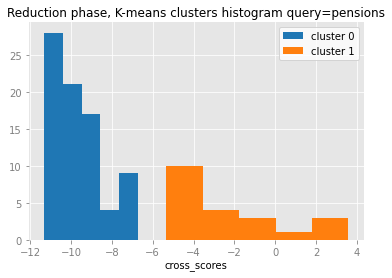

,score,cross_scores,File description,Full path,Link
3,0.500756,3.587445,Partial retirement pension,Partial retirement pension. Partial retirement...,https://ec.europa.eu/eurostat/statistics-expla...
0,0.580586,3.091249,Expenditure on pensions,Expenditure on pensions. Expenditure on pensio...,https://ec.europa.eu/eurostat/statistics-expla...
1,0.545538,2.333605,Old age pension,Old age pension. Old age pension periodic paym...,https://ec.europa.eu/eurostat/statistics-expla...
2,0.514480,0.204849,Early retirement,Early retirement. Early retirement in case of ...,https://ec.europa.eu/eurostat/statistics-expla...
4,0.408623,-0.219874,Aggregate replacement ratio,Aggregate replacement ratio. The aggregate rep...,https://ec.europa.eu/eurostat/statistics-expla...
8,0.336658,-1.667403,Social benefits,Social benefits. Social benefits other than so...,https://ec.europa.eu/eurostat/statistics-expla...
5,0.380884,-1.710697,Social transfers,Social transfers. Social transfers cover the s...,https://ec.europa.eu/eurostat/statistics-expla...
15,0.274068,-2.230033,Household saving,Household saving. Household saving total savin...,https://ec.europa.eu/eurostat/statistics-expla...
14,0.275317,-2.664861,Compensation,Compensation. The compensation of employees co...,https://ec.europa.eu/eurostat/statistics-expla...
18,0.261861,-2.876572,Disposable income,Disposable income. Disposable income includes ...,https://ec.europa.eu/eurostat/statistics-expla...


bot: Can we make it more specific? Is 'disposable income' related to what you are looking for? (yes/no/add some keywords/no with keywords, q to quit) 
me:  no


,score,cross_scores,File description,Full path,Link
3,0.500756,3.587445,Partial retirement pension,Partial retirement pension. Partial retirement...,https://ec.europa.eu/eurostat/statistics-expla...
0,0.580586,3.091249,Expenditure on pensions,Expenditure on pensions. Expenditure on pensio...,https://ec.europa.eu/eurostat/statistics-expla...
1,0.545538,2.333605,Old age pension,Old age pension. Old age pension periodic paym...,https://ec.europa.eu/eurostat/statistics-expla...
2,0.514480,0.204849,Early retirement,Early retirement. Early retirement in case of ...,https://ec.europa.eu/eurostat/statistics-expla...
4,0.408623,-0.219874,Aggregate replacement ratio,Aggregate replacement ratio. The aggregate rep...,https://ec.europa.eu/eurostat/statistics-expla...
8,0.336658,-1.667403,Social benefits,Social benefits. Social benefits other than so...,https://ec.europa.eu/eurostat/statistics-expla...
5,0.380884,-1.710697,Social transfers,Social transfers. Social transfers cover the s...,https://ec.europa.eu/eurostat/statistics-expla...
15,0.274068,-2.230033,Household saving,Household saving. Household saving total savin...,https://ec.europa.eu/eurostat/statistics-expla...
14,0.275317,-2.664861,Compensation,Compensation. The compensation of employees co...,https://ec.europa.eu/eurostat/statistics-expla...
18,0.261861,-2.876572,Disposable income,Disposable income. Disposable income includes ...,https://ec.europa.eu/eurostat/statistics-expla...


bot: Is 'social contributions' related to what you are looking for? (yes/no/add some keywords/no with keywords, q to quit) 
me:  no


,score,cross_scores,File description,Full path,Link
3,0.500756,3.587445,Partial retirement pension,Partial retirement pension. Partial retirement...,https://ec.europa.eu/eurostat/statistics-expla...
0,0.580586,3.091249,Expenditure on pensions,Expenditure on pensions. Expenditure on pensio...,https://ec.europa.eu/eurostat/statistics-expla...
1,0.545538,2.333605,Old age pension,Old age pension. Old age pension periodic paym...,https://ec.europa.eu/eurostat/statistics-expla...
2,0.514480,0.204849,Early retirement,Early retirement. Early retirement in case of ...,https://ec.europa.eu/eurostat/statistics-expla...
4,0.408623,-0.219874,Aggregate replacement ratio,Aggregate replacement ratio. The aggregate rep...,https://ec.europa.eu/eurostat/statistics-expla...
8,0.336658,-1.667403,Social benefits,Social benefits. Social benefits other than so...,https://ec.europa.eu/eurostat/statistics-expla...
5,0.380884,-1.710697,Social transfers,Social transfers. Social transfers cover the s...,https://ec.europa.eu/eurostat/statistics-expla...
15,0.274068,-2.230033,Household saving,Household saving. Household saving total savin...,https://ec.europa.eu/eurostat/statistics-expla...
14,0.275317,-2.664861,Compensation,Compensation. The compensation of employees co...,https://ec.europa.eu/eurostat/statistics-expla...
18,0.261861,-2.876572,Disposable income,Disposable income. Disposable income includes ...,https://ec.europa.eu/eurostat/statistics-expla...


bot: Let's make it more specific. Are you interested in 'old age'? (yes/no/add some keywords/no with keywords, q to quit) 
me:  no


,score,cross_scores,File description,Full path,Link
3,0.500756,3.587445,Partial retirement pension,Partial retirement pension. Partial retirement...,https://ec.europa.eu/eurostat/statistics-expla...
0,0.580586,3.091249,Expenditure on pensions,Expenditure on pensions. Expenditure on pensio...,https://ec.europa.eu/eurostat/statistics-expla...
1,0.545538,2.333605,Old age pension,Old age pension. Old age pension periodic paym...,https://ec.europa.eu/eurostat/statistics-expla...
2,0.514480,0.204849,Early retirement,Early retirement. Early retirement in case of ...,https://ec.europa.eu/eurostat/statistics-expla...
4,0.408623,-0.219874,Aggregate replacement ratio,Aggregate replacement ratio. The aggregate rep...,https://ec.europa.eu/eurostat/statistics-expla...
8,0.336658,-1.667403,Social benefits,Social benefits. Social benefits other than so...,https://ec.europa.eu/eurostat/statistics-expla...
5,0.380884,-1.710697,Social transfers,Social transfers. Social transfers cover the s...,https://ec.europa.eu/eurostat/statistics-expla...
15,0.274068,-2.230033,Household saving,Household saving. Household saving total savin...,https://ec.europa.eu/eurostat/statistics-expla...
14,0.275317,-2.664861,Compensation,Compensation. The compensation of employees co...,https://ec.europa.eu/eurostat/statistics-expla...
18,0.261861,-2.876572,Disposable income,Disposable income. Disposable income includes ...,https://ec.europa.eu/eurostat/statistics-expla...


bot: Are you interested to results related to 'social transfers'? (yes/no/add some keywords/no with keywords, q to quit) 
me:  no


,score,cross_scores,File description,Full path,Link
3,0.500756,3.587445,Partial retirement pension,Partial retirement pension. Partial retirement...,https://ec.europa.eu/eurostat/statistics-expla...
0,0.580586,3.091249,Expenditure on pensions,Expenditure on pensions. Expenditure on pensio...,https://ec.europa.eu/eurostat/statistics-expla...
1,0.545538,2.333605,Old age pension,Old age pension. Old age pension periodic paym...,https://ec.europa.eu/eurostat/statistics-expla...
2,0.514480,0.204849,Early retirement,Early retirement. Early retirement in case of ...,https://ec.europa.eu/eurostat/statistics-expla...
4,0.408623,-0.219874,Aggregate replacement ratio,Aggregate replacement ratio. The aggregate rep...,https://ec.europa.eu/eurostat/statistics-expla...
8,0.336658,-1.667403,Social benefits,Social benefits. Social benefits other than so...,https://ec.europa.eu/eurostat/statistics-expla...
5,0.380884,-1.710697,Social transfers,Social transfers. Social transfers cover the s...,https://ec.europa.eu/eurostat/statistics-expla...
15,0.274068,-2.230033,Household saving,Household saving. Household saving total savin...,https://ec.europa.eu/eurostat/statistics-expla...
14,0.275317,-2.664861,Compensation,Compensation. The compensation of employees co...,https://ec.europa.eu/eurostat/statistics-expla...
18,0.261861,-2.876572,Disposable income,Disposable income. Disposable income includes ...,https://ec.europa.eu/eurostat/statistics-expla...


bot: Please provide more details. Is 'risk poverty' something related to what you are looking for? (yes/no/add some keywords/no with keywords, q to quit) 
me:  no


,score,cross_scores,File description,Full path,Link
3,0.500756,3.587445,Partial retirement pension,Partial retirement pension. Partial retirement...,https://ec.europa.eu/eurostat/statistics-expla...
0,0.580586,3.091249,Expenditure on pensions,Expenditure on pensions. Expenditure on pensio...,https://ec.europa.eu/eurostat/statistics-expla...
1,0.545538,2.333605,Old age pension,Old age pension. Old age pension periodic paym...,https://ec.europa.eu/eurostat/statistics-expla...
2,0.514480,0.204849,Early retirement,Early retirement. Early retirement in case of ...,https://ec.europa.eu/eurostat/statistics-expla...
4,0.408623,-0.219874,Aggregate replacement ratio,Aggregate replacement ratio. The aggregate rep...,https://ec.europa.eu/eurostat/statistics-expla...
8,0.336658,-1.667403,Social benefits,Social benefits. Social benefits other than so...,https://ec.europa.eu/eurostat/statistics-expla...
5,0.380884,-1.710697,Social transfers,Social transfers. Social transfers cover the s...,https://ec.europa.eu/eurostat/statistics-expla...
15,0.274068,-2.230033,Household saving,Household saving. Household saving total savin...,https://ec.europa.eu/eurostat/statistics-expla...
14,0.275317,-2.664861,Compensation,Compensation. The compensation of employees co...,https://ec.europa.eu/eurostat/statistics-expla...
18,0.261861,-2.876572,Disposable income,Disposable income. Disposable income includes ...,https://ec.europa.eu/eurostat/statistics-expla...


bot: Can we make it more specific? Is 'social benefits' related to what you are looking for? (yes/no/add some keywords/no with keywords, q to quit) 
me:  yes
Optimal clusters:  3
   n_clusters  gap_value
0         2.0  -0.666851
1         3.0  -0.030238
real clusters:  3


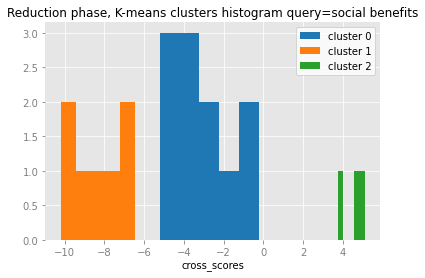

bot: Thank you. Here are the most relevant results of your query:


,score,cross_scores,File description,Full path,Link
2,0.541775,5.113944,Social benefits,Social benefits. Social benefits other than so...,https://ec.europa.eu/eurostat/statistics-expla...
0,0.603482,4.770149,Expenditure on pensions,Expenditure on pensions. Expenditure on pensio...,https://ec.europa.eu/eurostat/statistics-expla...
1,0.594662,3.726693,Social transfers,Social transfers. Social transfers cover the s...,https://ec.europa.eu/eurostat/statistics-expla...


In [87]:
# You may also change parameter show_inter_results here, from show_inter_results to True or False
query_results_df = chatbot.run(stop_after_multiple_no=6, stop_after_multiple_yes=5, show_inter_results=show_inter_results)